In [2]:
import nltk as nltk
import nltk.corpus  
from nltk.text import Text
from nltk.corpus import stopwords
import pandas as pd
import re
import sys
import matplotlib.pyplot as plt
import numpy as np
import scikitplot as skplt
import glob
import os
import spacy
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn import metrics


### Read in data

First section is only for the scored test set with generated summaries

In [9]:
# get max csv
# list_of_files = glob.glob('Z:/final_data/scored_data/scored_rouged_df*.csv') # * means all if need specific format then *.csv
# ckpt_text = max(list_of_files, key=os.path.getctime)
# print(ckpt_text)

# read in actual notes
# notes = pd.read_csv(ckpt_text,index_col=0,keep_default_na=False)

Z:/final_data/scored_data\scored_rouged_df.csv


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (2,70,326) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
# notes.head()

,patient_id,age_at_last_encounter,gender,race,ethnicity,date_of_death,encounter_id,enc_eio,visit_status_1,visit_status_2,...,scored_summaries,rouge-1-f,rouge-1-p,rouge-1-r,rouge-2-f,rouge-2-p,rouge-2-r,rouge-l-f,rouge-2-p.1,rouge-2-r.1
0,49,79,M,White,Not Hispanic or Latino,,10440586,O,Completed,,...,,,,,,,,,,
1,49,79,M,White,Not Hispanic or Latino,,10440586,O,Completed,,...,,,,,,,,,,
2,49,79,M,White,Not Hispanic or Latino,,10440586,O,Completed,,...,,,,,,,,,,
3,49,79,M,White,Not Hispanic or Latino,,10440586,O,Completed,,...,,,,,,,,,,
4,49,79,M,White,Not Hispanic or Latino,,11420608,O,No Show,Completed,...,,,,,,,,,,


In [3]:
# train dat
train_dta = pd.read_csv("Z:/final_data/cohorts_merged_training.csv",keep_default_na=False)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (1,69,325) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
train_dta.head()

,patient_id,age_at_last_encounter,gender,race,ethnicity,date_of_death,encounter_id,enc_eio,visit_status_1,visit_status_2,...,technique,comparison,findings,impressions,elecsig,patient_raw,rawtext,encounter_id_diagnosed,date_diagnosed,ild_status
0,2068804,60,F,White,Not Hispanic or Latino,,7629913,I,Completed,,...,XR PORT CHEST 1V,None,Small lung volumes with bilateral airspace and...,Findings consistent with CHF/fluid overload.,**DATE<[**2017-09-06**]> 9:53 AM **NAME<EEE F...,7629913_446136,"XR PORT CHEST 1V, **DATE<[**2017-09-06**]> 9:1...",,,0
1,2068842,54,M,Black/African-American,Not Hispanic or Latino,,6781649,O,Completed,,...,,,,,,,,,,0
2,2068842,54,M,Black/African-American,Not Hispanic or Latino,,6781649,O,Completed,,...,Noncontrast thin section axial CT images of th...,None.,There is evidence of prior endoscopic surgery ...,1. Mild paranasal sinus disease including muco...,**DATE<[**2017-09-06**]> 1:36 PM **NAME<ZZZ AA...,6781649_1155203,"CT [**Company 1**] FUSION WO CONTRAST, **DATE<...",,,0
3,2068842,54,M,Black/African-American,Not Hispanic or Latino,,7649307,O,Completed,,...,,,,,,,,,,0
4,2068866,36,F,White,Hispanic or Latino,,7589589,O,Completed,,...,XR CHEST PA/LATERAL,None.,Right upper lobe resection via thoracotomy wit...,No significant abnormality.,**DATE<[**2017-08-21**]> 3:53 PM **NAME<EEE FF...,7589589_108353,"XR CHEST PA/LATERAL, **DATE<[**2017-08-21**]> ...",,,0


In [5]:
train_dta['ild_diag_prior_to_visit'] = np.where(train_dta['adm_date_d'] < train_dta['date_diagnosed'], 0, 1)

### Let's get only the rows with an impression to build off of. 

We'll need to grab the rows where the ild_diag_prior_to_visit is 0, and has a "finding"

In [6]:
train_dta.head().loc[train_dta.findings.notnull()]

,patient_id,age_at_last_encounter,gender,race,ethnicity,date_of_death,encounter_id,enc_eio,visit_status_1,visit_status_2,...,comparison,findings,impressions,elecsig,patient_raw,rawtext,encounter_id_diagnosed,date_diagnosed,ild_status,ild_diag_prior_to_visit
0,2068804,60,F,White,Not Hispanic or Latino,,7629913,I,Completed,,...,None,Small lung volumes with bilateral airspace and...,Findings consistent with CHF/fluid overload.,**DATE<[**2017-09-06**]> 9:53 AM **NAME<EEE F...,7629913_446136,"XR PORT CHEST 1V, **DATE<[**2017-09-06**]> 9:1...",,,0,1
1,2068842,54,M,Black/African-American,Not Hispanic or Latino,,6781649,O,Completed,,...,,,,,,,,,0,1
2,2068842,54,M,Black/African-American,Not Hispanic or Latino,,6781649,O,Completed,,...,None.,There is evidence of prior endoscopic surgery ...,1. Mild paranasal sinus disease including muco...,**DATE<[**2017-09-06**]> 1:36 PM **NAME<ZZZ AA...,6781649_1155203,"CT [**Company 1**] FUSION WO CONTRAST, **DATE<...",,,0,1
3,2068842,54,M,Black/African-American,Not Hispanic or Latino,,7649307,O,Completed,,...,,,,,,,,,0,1
4,2068866,36,F,White,Hispanic or Latino,,7589589,O,Completed,,...,None.,Right upper lobe resection via thoracotomy wit...,No significant abnormality.,**DATE<[**2017-08-21**]> 3:53 PM **NAME<EEE FF...,7589589_108353,"XR CHEST PA/LATERAL, **DATE<[**2017-08-21**]> ...",,,0,1


In [7]:
train_dta_ild = train_dta[(train_dta.ild_diag_prior_to_visit==0) & (train_dta.findings.str.len()>0)]
train_dta_ild.shape

(10174, 342)

this is different from source...

### Spacy cleaning

Note english language is not installed. Somebody with sudo needs to run:

python -m spacy download en

@chantel Please submit a ticket

In [16]:
nlp = spacy.load("en", disable=['parser', 'tagger', 'ner'])
stops = stopwords.words("english")

def normalize(comment, lowercase, remove_stopwords):
    if lowercase:
        comment = comment.lower()
    comment = nlp(comment)
    lemmatized = list()
    for word in comment:
        lemma = word.lemma_.strip()
        if lemma:
            if not remove_stopwords or (remove_stopwords and lemma not in stops):
                lemmatized.append(lemma)
    return " ".join(lemmatized)

train_dta_ild['findings_cleaned'] = train_dta_ild['findings'].apply(normalize,lowercase=True,remove_stopwords=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [17]:
train_dta_ild.head()

,patient_id,age_at_last_encounter,gender,race,ethnicity,date_of_death,encounter_id,enc_eio,visit_status_1,visit_status_2,...,findings,impressions,elecsig,patient_raw,rawtext,encounter_id_diagnosed,date_diagnosed,ild_status,ild_diag_prior_to_visit,findings_cleaned
288,2069132,69,F,Black/African-American,Not Hispanic or Latino,,7891777,I,Completed,,...,Heart size is normal. Dense left retrocardiac...,1. Bilateral hilar masses as noted on the CT e...,"**NAME<VVV WWW>, MD I personally reviewed the...",7891777_507176,"XR CHEST PA/LATERAL, **DATE<[**2017-07-28**]> ...",6637510,2015-01-04,1,0,heart size normal . dense leave retrocardiac o...
398,2069285,75,F,White,Not Hispanic or Latino,,7159367,O,Completed,,...,CHEST: \r\n\r\nLUNGS AND PLEURA: Right upper ...,1. Interval improvement/decrease size of refe...,**DATE<[**2018-09-18**]> 3:06 PM **NAME<ZZZ AA...,7159367_46113,ADDENDUM: Addendum for coding purposes only: C...,6667347,2015-09-03,1,0,chest : lung pleura : right upper lobe granulo...
403,2069285,75,F,White,Not Hispanic or Latino,,7381285,O,Completed,,...,CHEST: \r\n\r\nLUNGS AND PLEURA: Visualized l...,1. Interval increase in size of retroperitonea...,**DATE<[**2018-04-16**]> 4:18 PM **NAME<FFF GG...,7381285_1081943,CT CHEST ABDOMEN PELVIS W; **DATE<[**2018-04-1...,6667347,2015-09-03,1,0,chest : lung pleura : visualize lung field sta...
406,2069285,75,F,White,Not Hispanic or Latino,,7507207,O,Completed,,...,There is no evidence of intracranial mass or a...,No evidence of intracranial metastases.,**DATE<[**2018-03-14**]> 8:46 AM **NAME<XXX YY...,7507207_600706,"CT HEAD W, **DATE<[**2018-03-13**]> 4:58 PM \...",6667347,2015-09-03,1,0,evidence intracranial mass abnormal enhancemen...
407,2069285,75,F,White,Not Hispanic or Latino,,7507207,O,Completed,,...,CHEST: \r\n\r\nLUNGS AND PLEURA: Probable cal...,Scattered small lymph nodes. Pulmonary micron...,**DATE<[**2018-03-26**]> 1:45 PM **NAME<ZZZ A...,7507207_769042,ADDENDUM: ADDENDUM: AFTER FURTHER DISCUSSION W...,6667347,2015-09-03,1,0,chest : lung pleura : probable calcify granulo...


In [18]:
X = np.array(train_dta_ild.findings)
Y = np.array(train_dta_ild.ild_status)
print(X.shape)
print(Y.shape)


(10174,)
(10174,)


In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,random_state=1)
print(X_train.shape)
print(X_test.shape)


(7630,)
(2544,)


In [21]:
vect = CountVectorizer()
vect.fit(X_train)
X_train_dtm = vect.transform(X_train)


In [22]:
# test
X_test_dtm = vect.transform(np.array(X_test))
X_test_dtm


<2544x6160 sparse matrix of type '<class 'numpy.int64'>'
	with 133504 stored elements in Compressed Sparse Row format>

## Model building

#### Naive bayes

In [69]:
nb = MultinomialNB()
# train and time the model using X_train_dtm
%time nb.fit(X_train_dtm, Y_train)

Wall time: 391 ms


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [70]:
# class preds
Y_pred_class_nb = nb.predict(X_test_dtm)

# calculate accuracy of class predictions
print(metrics.accuracy_score(Y_test, Y_pred_class_nb))

0.5625837864504574


             precision    recall  f1-score   support

          0       0.97      0.55      0.70     86779
          1       0.11      0.74      0.19      6464

avg / total       0.91      0.56      0.66     93243

[[47643 39136]
 [ 1650  4814]]


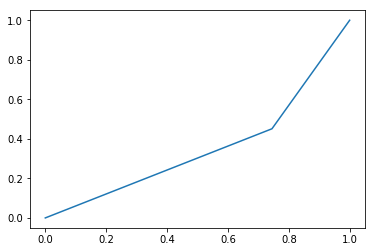

AUC: 0.35312229311250304


In [71]:
# calculate precision and recall
print(classification_report(Y_test, Y_pred_class_nb))

# calculate the confusion matrix
print(metrics.confusion_matrix(Y_test, Y_pred_class_nb))

fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_pred_class_nb, pos_label=0)

# Print ROC curve
plt.plot(fpr,tpr)
plt.show() 

# Print AUC
auc = np.trapz(tpr,fpr)
print('AUC:', auc)